In [1]:
import os 
import pandas as pd  

In [2]:
CO2_1 = "CO2mofsimplify_list_seed42_1000_part1"
CO2_2 = "CO2mofsimplify_list_seed42_1000_part2"
O2_1 = "O2mofsimplify_list_seed42_500_part1"

NaN만 있는 MOFs: ['ABETAE_clean', 'PETXAP_clean', 'WEWTOI_clean']
NaN이 아닌 값 포함된 MOFs: ['ACODAZ_clean', 'ADAVIM_clean', 'AHAMAY_clean']

예시 MOF 내용:
MOF: ACODAZ_clean
Elements: ['C', 'H', 'C', 'H', 'C', 'H', 'C', 'H', 'C', 'H', 'C', 'H', 'C', 'H', 'C', 'H', 'C', 'H', 'C', 'H']
Charges: [0.0104941, 0.0496185, 0.0104941, 0.0496185, 0.0104941, 0.0496185, 0.0104941, 0.0496185, 0.0104941, 0.0496185, 0.0104941, 0.0496185, 0.0104941, 0.0496185, 0.0104941, 0.0496185, 0.0104941, 0.0496185, 0.0104941, 0.0496185]


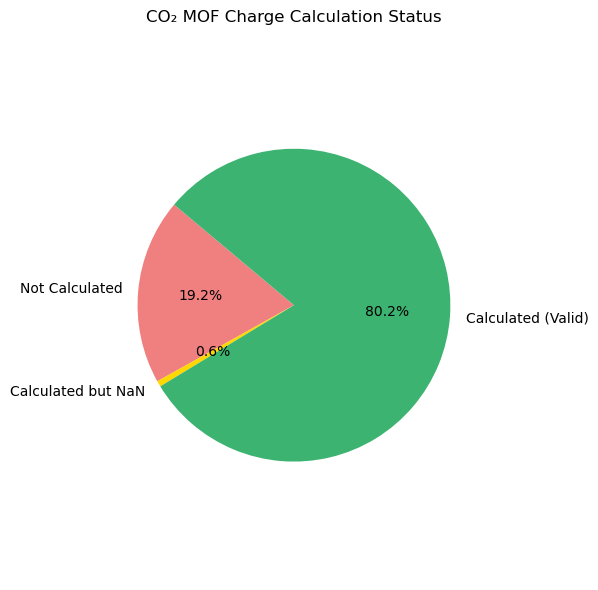

In [ ]:
import os
import pandas as pd
import numpy as np
from collections import defaultdict
CO2_1 = "CO2mofsimplify_list_seed42_1000_part1"
CO2_2 = "CO2mofsimplify_list_seed42_1000_part2"
O2_1 = "O2mofsimplify_list_seed42_500_part1"
os.chdir(CO2_1)
CO2_1_DF = pd.read_csv("./07result.csv")

dirs = [d for d in os.listdir() if os.path.isdir(d)]

# MOF 결과 저장
mof_charges_dict = {}          # MOF별 {"elements": [...], "charges": [...]}
nan_status_dict = {"nan": [], "not_nan": []}

for name in CO2_1_DF["name"].to_list():
    for d in dirs:
        if name in d:
            d2 = os.path.join(d, "Movies", "System_0")
            try:
                cif_file = [x for x in os.listdir(d2) if "final" in x and "P1.cif" in x][0]
                calcedcifpath = os.path.join(d2, cif_file)
            except (FileNotFoundError, IndexError):
                continue

            elements = []
            charges = []

            with open(calcedcifpath, 'r') as f:
                lines = f.readlines()
                atom_data_started = False
                for line in lines:
                    if "_atom_site_charge" in line:
                        atom_data_started = True
                        continue
                    if atom_data_started:
                        parts = line.split()
                        if len(parts) >= 6:
                            element = parts[1]
                            try:
                                charge = float(parts[5])
                            except ValueError:
                                charge = np.nan
                            elements.append(element)
                            charges.append(charge)

            # NaN 체크해서 분류
            if all(np.isnan(charge) for charge in charges):
                nan_status_dict["nan"].append(name)
            else:
                nan_status_dict["not_nan"].append(name)

            # 저장
            mof_charges_dict[name] = {
                "elements": elements,
                "charges": charges
            }



# 예시 출력
print("NaN만 있는 MOFs:", nan_status_dict["nan"][:3])
print("NaN이 아닌 값 포함된 MOFs:", nan_status_dict["not_nan"][:3])

print("\n예시 MOF 내용:")
example_name = nan_status_dict["not_nan"][0]
print("MOF:", example_name)
print("Elements:", mof_charges_dict[example_name]["elements"][:20])
print("Charges:", mof_charges_dict[example_name]["charges"][:20])


import matplotlib.pyplot as plt

# === 전체 타겟 MOF 목록 불러오기 ===
with open("../CO2mofsimplify_list_seed42_1000_part1/mofsimplify_list_seed42_1000_part1.txt", 'r') as f:
    TARGET_MOFS_TOTAL = f.read().strip().split('\n')
    total_mof_count = len(TARGET_MOFS_TOTAL)

# === 계산된 MOFs 이름 리스트 ===
calculated_mofs = CO2_1_DF["name"].to_list()

# === 계산되지 않은 MOFs ===
not_calculated = list(set(TARGET_MOFS_TOTAL) - set(calculated_mofs))

# === 개수 세기 ===
num_not_calculated = len(not_calculated)
num_nan = len(nan_status_dict["nan"])
num_not_nan = len(nan_status_dict["not_nan"])

# === 원형 차트 시각화 ===
labels = ['Not Calculated', 'Calculated but NaN', 'Calculated (Valid)']
sizes = [num_not_calculated, num_nan, num_not_nan]
colors = ['lightcoral', 'gold', 'mediumseagreen']

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title("CO₂ MOF Charge Calculation Status")
plt.axis('equal')  # 원형 유지
plt.tight_layout()
plt.show()

os.chdir("../")